# 1D-CAE Tester

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler

from utils import *
from cnn import *

In [2]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-f3c6115e-46cd-6ccc-eedb-5f06a170552d)


## Data Pre-Processing

In [3]:
freq = '5min' # 5min

In [4]:
zone_name = 'zone7'
model_path = './model_savings/'+zone_name+'.pth'

In [5]:
data_path = './data/l-town-data/2019_SCADA_Pressures.csv'

In [6]:
sensors_list = {

'zone1' : ['n1','n4','n31'],

'zone2' : ['n410','n429'],

'zone3' : ['n342','n636','n644'],

'zone4' : ['n296','n679','n722','n740'],

'zone5' : ['n288','n726','n752','n769'],

'zone6' : ['n215','n229'],

'zone7' : ['n163','n188','n613'],

'zone8' : ['n332','n495','n506','n549'],

'zone9' : ['n105','n114','n469', 'n516'],

'zone10' : ['n54','n415','n458', 'n519']
    
}

In [7]:
zone_sensors = sensors_list[zone_name]

In [8]:
#Read data
scada = pd.read_csv(data_path, sep=';', decimal=',', index_col='Timestamp')#, nrows=1000)
scada.index = pd.date_range(start=scada.index[0], periods=len(scada), freq=freq)
scada = scada.loc[:, zone_sensors]

### Data proprocess

In [9]:
start_time = pd.Timestamp('2019-01-01 00:00')
split_time = pd.Timestamp('2019-01-15 00:00')

In [10]:
train = scada[start_time:split_time]
test = scada[split_time:]

In [11]:
scaler = StandardScaler()
scaler.fit(train)
x_scaled = scaler.transform(test)
test = pd.DataFrame(x_scaled)

### Sliding window

In [12]:
window_size=288
step = 1

In [13]:
windows_test=test.values[np.arange(window_size)[None, :] + np.arange(test.shape[0]-window_size)[::step, None]]
windows_test = windows_test.swapaxes(1,2)
windows_test.shape

(100800, 3, 288)

## Read model

In [14]:
feature_size=windows_test.shape[1]
seq_len=windows_test.shape[2]
BATCH_SIZE = 144

In [15]:
model = CNN(feature_size, seq_len)
model = to_device(model,device)

checkpoint = torch.load(model_path)

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

## Testing

In [16]:
len_test = windows_test.shape[0]

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
                torch.from_numpy(windows_test).float()
                ) , batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
results, _, _=testing(model,test_loader)
test_err=torch.cat(results, dim=0).detach().cpu().numpy()

In [17]:
offset = pd.DateOffset(minutes=5*window_size)

start_date = start_time + offset

res = pd.DataFrame(test_err, columns=sensors_list[zone_name])
res.index = pd.date_range(start=start_date,periods=len(res),freq=freq)

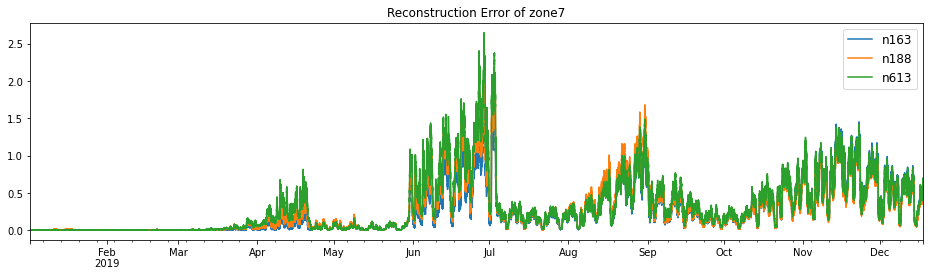

In [18]:
fig, ax = plt.subplots(figsize=(16,4))

for i in res.keys():
    res[i].plot(label = i)

plt.legend(prop={'size': 12})
plt.title(f'Reconstruction Error of {zone_name}')
plt.show()

In [19]:
save_path = 'reconstruct_error'
check_and_create_directory(save_path)

Directory 'reconstruct_error' already created.


In [20]:
# Save reconstruction error of zone
res.to_csv(f'./{save_path}/{zone_name}.csv')